In [1]:
import torch
from efficientnet_pytorch import EfficientNet

In [2]:
model = EfficientNet.from_name('efficientnet-b6', num_classes=1)
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
model.eval();

In [3]:
model.set_swish(memory_efficient=False)
torch.onnx.export(model, torch.rand(1,3,224,224), 'model.onnx')

In [6]:
# !pip3 install onnxruntime

import onnxruntime
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

def pad(im):
    w, h = im.size; m = np.max([w, h])
    hp, hpr = (m - w) // 2, (m - w) % 2
    vp, vpr = (m - h) // 2, (m - h) % 2
    return (hp + hpr, vp + vpr, hp, vp)

def norm(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (x - mean) / std

def denorm(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return np.clip(std * x + mean, 0, 1)

def load_image(path, size):
    im = Image.open(path)
    im.thumbnail((size, size), Image.ANTIALIAS)
    im = ImageOps.expand(im, pad(im))
    return np.array(im) / 255.

def to_tensor(x):
    x = np.float32(norm(x))
    x = x.transpose(2,0,1)
    return x.reshape((1,) + x.shape)

def to_image(x):
    x = x.squeeze()
    x = x.transpose(1,2,0)
    return denorm(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

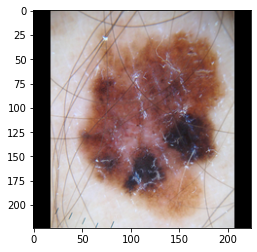

In [7]:
plt.imshow(load_image('1.jpg', 224));

In [8]:
ort_session = onnxruntime.InferenceSession('model.onnx')

In [9]:
x = to_tensor(load_image('1.jpg', 224))
inps = {ort_session.get_inputs()[0].name: x}
outs = ort_session.run(None, inps)

In [10]:
sigmoid(outs[0])[0][0]

0.9985442